# Image Classification with Convolutional Nural Networks (Tensorflow)



## Introduction

In this notebook, I am going to build, train and validate **convolutional neural networks** (ConvNets).
For this purpose, I will use data from the publicly available CIFAR10 dataset.
CIFAR10 is a dataset commonly used in the community of computer vision and machine learning to benchmark new algorithms and network architectures.

CIFAR10 is a dataset that contains (small) RGB images of 32x32 px of ten different classes:

    * airplane
    * automobile
    * bird
    * cat
    * deer
    * dog
    * frog
    * horse
    * ship
    * truck
More details can be found at this link: https://www.cs.toronto.edu/~kriz/cifar.html

Based on an overview found on this website: https://paperswithcode.com/sota/image-classification-on-cifar-10, the current state-of-the-art result on this dataset has reached an accuracy of 99.7%.

## Data
I will train ConvNet with images from CIFAR10, a dataset of 60,000 color images of 32x32 pixels in 10 classes. The downloaded training samples come split into 5 batches of 10,000 samples each, which is useful to do cross-validation for example. In this assignment, I will have to decide how to best split the dataset into training and validation sets. A separate test set is provided in CIFAR10, which is the same set used by other researchers to benchmark their methods.

## Tasks
I define 10 tasks in this assignment.

Given the experience I have gained by defining datasets and training neural networks, training convolutional neural networks is just a natural step towards using a different architectures (and some additional tricks and tools).

---

The task that I propose are the following:

### Task 1. Split data and build convolutional networks
In this task, I will first define training and validation set, then I will build the architecture of convolutional networks.

### Task 2. Train convolutional networks
In this task, I will train your first model using CIFAR10, apply the trained model to the test set.

### Task 3. Add dropout layer(s)
In this task, I will modify the architecture of your network by adding dropout, which is implemented in Keras in the form of a layer. After that, I will repeat the training procedure and compare the results with the ones of the *plain* network.

### Task 4. Add batch normalization
In this task, I will do something similar to task 3, but now adding batch normalization.
I will repeat the experiment and compare the performance with previous architectures.

### Task 5. Try different initialization strategies
I have seen that at least a couple of initilization strategies are known in the literature for (convolutional) neural networks.
Several strategies are implemented in the Keras library. I will try some of them.

### Task 6. Try different nonlinearities
The same for nonlinearities, I have seen that ```ReLU``` is some kind of default choice for ConvNets, but other strategies exists.

### Task 7. Add L2 regularization
I will modify the loss function to use L2 regularization.

### Task 8. Add data augmentation
I will think of possible ways to augment the (training) data. For example building a new (bigger) training set, or implement some kind of data augmentation *on-the-fly*, where some patches in the mini-batch are randomly selected and augmented with a (random) operation. 

### Task 9. Try a different architecture
I will try to improve the performance by modifying the architecture, using more layers, or wider layers (same number of layers but more filters, which means more parameters), like the optimal combination of the options. The goal is to get high accuracy on the validation (and therefore on the test) set!

### Task 10. Monitor the training procedure
Finally, I will implement some tools to monitor the training procedure.

## Let's get started

In [1]:
# import libraries
import numpy as np
import os #operation system
import pickle
import matplotlib.pyplot as plt
# %matplotlib inline
from tqdm import tnrange, tqdm_notebook
from IPython import display
import time
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras import models, layers, activations
from keras.models import Model
from PIL import Image, ImageFilter
from keras import regularizers

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/Users/zah47/Library/Python/3.9/lib/python/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 2.0.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/zah47/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/zah47

AttributeError: _ARRAY_API not found

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11292358556870444766
xla_global_id: -1
]


## Get to know your data: Load data and define datasets

CIFAR10 contains 5 batches that can be used for training/validation, and one batch that consists of the test set.
In order to train your network, you will have to define a training set and a validation set. Do not use the test set as training data, and do not use any knowledge on the labels of the test set (being a publicly available dataset, we cannot avoid exposing the labels of the test set).


Think of the best way to split data into training and validation set. Note that the format that layers in convolutional networks like (at least in the Keras/Tensorflow libraries that we are using), is as follows:

    (n_samples, rows, cols, n_channels)

This means that each training (but also validation and test) sample needs to have four dimensions. This kind of structure (multi-dimensional array), is called a **tensor**. In practice, this format is also convenient because the first index of the tensor refers to the sample itself, so we can use:

    tensor[i]
    
to extract the i-th example.

During training, several samples will be used to update the parameters of a network. In the case of CIFAR10, if we use M samples per mini-batch, the shape of the mini-batch data is:

    (M, 32, 32, 3)

Make sure data is organized in this way, for the training, validation and test datasets.

### Download CIFAR10 data
The following cell will download the 5 batches of the CIFAR10 training dataset as well as the test set to your disk and load it in memory.

In [2]:
from tensorflow.keras.utils import get_file
origin_url = 'https://surfdrive.surf.nl/files/index.php/s/{key}/download'

# Dictionary mapping file names to download keys
files = {
    'cifar10-batch-1': '4Nee36XgbYjp3N6',
    'cifar10-batch-2': 'LVx85dLceKI5toF',
    'cifar10-batch-3': '4FoFmeKyXa5sYr0',
    'cifar10-batch-4': 'a4o2RatC0Fa3Exb',
    'cifar10-batch-5': 'eqBJRWdkRGk025k',
    'cifar10-test': 'nEf9Z4eg7iGmWGU'
}

# Download files to local drive (only downloads the files once)
local_files = [{'name': n,
                'file': get_file(n, origin=origin_url.format(key=k))} for n,
                k in files.items()]

# Load all batches in memory
batches = {lf['name']: pickle.load(open(lf['file'], 'rb'),
                                   encoding='latin1') for lf in local_files}

# Convert data to floats and reshape to correct format
# This is specific for CIFAR10
for batch in batches.values():
    # Images were originally used as (CxWxH), convert to (WxHxC)
    batch['data'] = (batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.).astype("float32")

data_size_in = (32, 32, 3)
n_classes=10

The CIFAR dataset is now loaded in memory in the form of a Python dictionary. To get to know your data, check what are the keys of such a dictionary:

In [3]:
print(batches.keys())

dict_keys(['cifar10-batch-1', 'cifar10-batch-2', 'cifar10-batch-3', 'cifar10-batch-4', 'cifar10-batch-5', 'cifar10-test'])


Before defining the datasets, it is useful to check the distribution of labels across batches of CIFAR10, in case some batches have skewed distributions of labels.
In order to do that, I use visualize the histogram of labels using the function ```hist()``` of the matplotlib library:

    plt.hist()

Text(0.5, 1.0, 'batch_5')

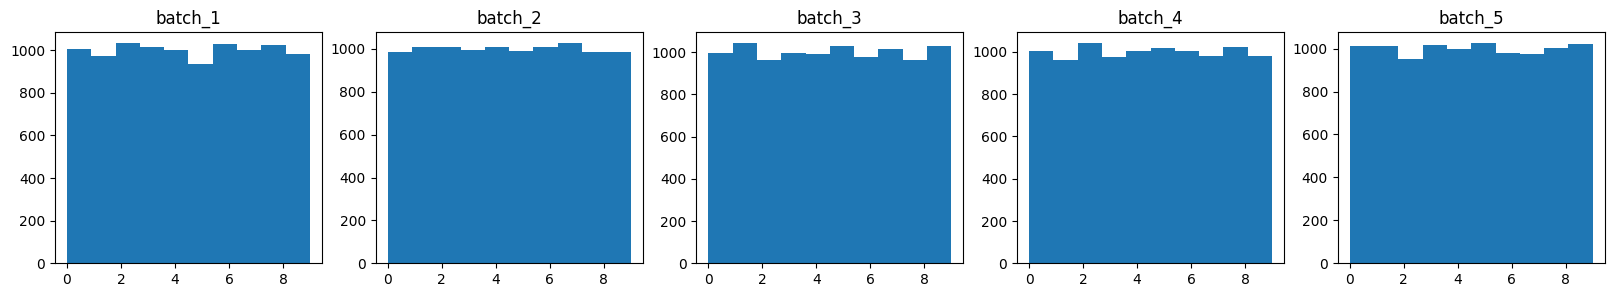

In [4]:
fig = plt.figure(figsize=(20, 3))
plt.subplot(1,5,1); plt.hist(batches['cifar10-batch-1']['labels']); plt.title('batch_1')
plt.subplot(1,5,2); plt.hist(batches['cifar10-batch-2']['labels']); plt.title('batch_2')
plt.subplot(1,5,3); plt.hist(batches['cifar10-batch-3']['labels']); plt.title('batch_3')
plt.subplot(1,5,4); plt.hist(batches['cifar10-batch-4']['labels']); plt.title('batch_4')
plt.subplot(1,5,5); plt.hist(batches['cifar10-batch-5']['labels']); plt.title('batch_5')

Implement now a function ```load_data``` that builds and returns the training and validation datasets. 

In [5]:
# define training, validation and test sets
def load_data():

    # make training set
    train_x = np.zeros((40000, 32, 32, 3)).astype("float32")
    train_x[0:10000] = batches['cifar10-batch-1']['data']
    train_x[10000:20000] = batches['cifar10-batch-2']['data']
    train_x[20000:30000] = batches['cifar10-batch-3']['data']
    train_x[30000:40000] = batches['cifar10-batch-4']['data']

    # ADD DATA TO THE VARIABLE x_train

    train_y = np.zeros((40000))
    train_y[0:10000] = batches['cifar10-batch-1']['labels']
    train_y[10000:20000] = batches['cifar10-batch-2']['labels']
    train_y[20000:30000] = batches['cifar10-batch-3']['labels']
    train_y[30000:40000] = batches['cifar10-batch-4']['labels']

    # make validation set
    val_x = batches['cifar10-batch-5']['data']
    val_y = batches['cifar10-batch-5']['labels']

    # make test set
    test_x = batches['cifar10-test']['data']

    # load labels CIFAR10
    label_to_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',
                      4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

    print ("-----------------------------------------------------")
    print (label_to_names)
    print ("-----------------------------------------------------")
    print ("> shape training set tensor: {}".format(train_x.shape))
    print ("> length training labels: {}".format(len(train_y)))
    print ("-----------------------------------------------------")
    print ("> shape validation set tensor: {}".format(val_x.shape))
    print ("> length training labels: {}".format(len(val_y)))
    print ("-----------------------------------------------------")
    print ("> shape test set tensor: {}".format(test_x.shape))

    return train_x, train_y, val_x, val_y, test_x

Note that Keras also provides the option to directly import popular datasets (see https://www.tensorflow.org/api_docs/python/tf/keras/datasets), which is helpful to quickly set-up your future experiments.

# Task 1: build a simple convolutional network

In this task I will create the definition of convolutional network. Check out the **functional API** of Keras; this API enables us to make more advanced models and is more flexible to use. A guide can be found here: https://www.tensorflow.org/api_docs/python/tf/keras

Example of sequential API:
```python
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(32, input_dim=784), activation='relu')
model.add(layers.Dense(32, activation='relu')
model.add(layers.Dense(10, activation='softmax'))

model.compile(...)
```

Example of same model using the functional API (**recommended**):

```python
from keras import models, layers

inputs = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(...)
```

The functional API can look a bit more complex at start in comparision to the sequential API. However, it gives us access to each individual layer and lets us more easily build up the network. The only difference between the two APIs is the way to build up the network, all other parts (training, applying a network, etc.) are the same.

### Network
Define the network builder function.
We build a convolutional network that contains:

1. input layer
2. convolutional layer
3. max pooling layer
4. convolutional layer
5. max pooling layer
6. fully-connected layer(s)
7. soft-max layer

### Hints; It is better to: 

1. Select the number of convolutional and max pooling layers and choose the filter size so that the input image is shrinked to 5x5 before the fully connected layers.
2. Use at least one fully connected layer between the last convolutional layer and the output layer (which is the fully connected layer with softmax nonlinearity).


In [6]:
# Define your network builder function. You can assume the (32, 32, 3) input size.
def build_neural_network(data_size_in, n_classes):

    # feature extraaction with CNNs
    inputs = layers.Input(shape=data_size_in)
    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(inputs)
    network_2 = layers.MaxPool2D(pool_size=(2, 2))(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_2)
    network_4 = layers.MaxPool2D(pool_size=(2, 2))(network_3)
    network_5 = layers.Flatten()(network_4)
    # Classification with MLP
    network_6 = layers.Dense(128, activation='relu')(network_5)
    prediction = layers.Dense(n_classes, activation='softmax')(network_6)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [25]:
network = build_neural_network(data_size_in, n_classes)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,026 (1.34 MB)

 Trainable params: 350,026 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

None


## Loss function & Optimization Algorithm

Now that the architecture is defined, it is time to specify the two other components of the learning framework, namely the loss function and the optimization algorithm.

After defining these two components, I will have to **compile** the network using the function ```network.compile()```.

The ```network.compile()``` function requires the following input parameters:
1. loss function -> the loss function
2. optimizer -> the optimization algorithm
3. metrics -> the performance parameters you want to compute

Find information about how to use the ```compile()``` function at this page: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

### Loss
Then, I should define a function that, given the network, gets the predicted probability for a given input sample.
Since I am dealing with a multi-class classification problem, **categorical cross-entropy** seems a reasonable choice.

### Optimization algorithm
I also have to specify how we want to train the model. Optimizer algorithms need a **learning rate**, and further strategies to adapt the learning rate during training.

### Metrics
Since I am developing a classifier for a multi-class problem, the accuracy seems like a reasonable choice.

In [7]:
# experimental setup
ls = 'CategoricalCrossentropy' # define the (string) loss function
lr = 0.001 # pick a value for learning rate
#sgd = keras.optimizers.SGD(learning_rate=lr) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
adam_opt = keras.optimizers.Adam(learning_rate=lr)
metric = ['acc'] # define (Python) list of metrics


In [26]:
network.compile(loss=ls, optimizer=adam_opt, metrics=metric)

### One-hot encoding

using categorical cross-entropy as loss function, a representation of labels in the training (and later validation) data in a 'one-hot' form is needed. This means that if having 5 classes, the format of labels has to be the following:

* ```y_train = 1 -> [1, 0, 0, 0, 0]```
* ```y_train = 2 -> [0, 1, 0, 0, 0]```
* ```y_train = 3 -> [0, 0, 1, 0, 0]```
* ```y_train = 4 -> [0, 0, 0, 1, 0]```
* ```y_train = 5 -> [0, 0, 0, 0, 1]```

Lucky for us, Keras has implemented such a [function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical). I use that to convert the given format into a 'one-hot' format.

In [8]:
# Load data using the function we defined above
train_x, train_y, val_x, val_y, test_x = load_data()

-----------------------------------------------------
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
-----------------------------------------------------
> shape training set tensor: (40000, 32, 32, 3)
> length training labels: 40000
-----------------------------------------------------
> shape validation set tensor: (10000, 32, 32, 3)
> length training labels: 10000
-----------------------------------------------------
> shape test set tensor: (10000, 32, 32, 3)


In [9]:
train_y_one_hot = tf.keras.utils.to_categorical(train_y,
                                                num_classes=n_classes)

val_y_one_hot = tf.keras.utils.to_categorical(val_y,
                                              num_classes=n_classes)

# This should print: (40000, 10)
print('train_y_one_hot.shape: ', train_y_one_hot.shape)
# This should print: (10000, 10)
print('val_y_one_hot.shape: ', val_y_one_hot.shape)

# check number of samples per class
print (np.sum(train_y_one_hot, axis=0))
print (np.sum(val_y_one_hot, axis=0))

train_y_one_hot.shape:  (40000, 10)
val_y_one_hot.shape:  (10000, 10)
[3986. 3986. 4048. 3984. 4003. 3975. 4020. 4023. 3997. 3978.]
[1014. 1014.  952. 1016.  997. 1025.  980.  977. 1003. 1022.]


### Check validation performance before training
All the main components required to train the network have been defined now.
However, in order to properly monitor the behaviour of a network during training, we should check the performance (the accuracy) on a separate validation set, and see if it returns something sensible.
For this purpose, I use the function ```network.evaluate``` in Keras, and set the ```batch_size``` to a value that fits in GPU/CPU.

In [10]:
# validate the network
scores = network.evaluate(val_x, val_y_one_hot, batch_size=None)
val_loss = scores[0]
val_acc = scores[1]
print ('Initial validation accuracy = {:.2f}%'.format(100.*val_acc))

NameError: name 'network' is not defined

# Task 2: Train the network
Now it's time to define a function that does trains the convnet by updating parameters for each mini-batch. This function will have to inculde the two main steps that we implemented last week:

  1. a pass over the training set, to update the parameters
  2. a pass over the validation set, to check the performance.
  
During training/validation, I will have to store the loss and accuracy values, in order to visualize them after each epoch in a plot that shows the learning curves. This is useful to monitor the training procedure.

During training, I will also be saving to disk the parameters of the network wich has the best performance on the validation set. This will be stored as the file ```best_model.h5``` in the direcotry ```network_dir```, which by default is the root directory of this notebook.

I wrap the training code in a function so that you can re-use it of each of the tasks in this code.

In [11]:
# training phase
def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit(x_training, y_training, batch_size=batch_size)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x=x_validation, y=y_validation, batch_size=1)
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'm')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt],
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

## Task 2: Train the network
Now that all the parameters and the functions necessary to train and validate the network have been defined, I use this cell to run the exepriment. First, I will define a *network_name*, which will be used to (1) save the parameters of the trained network to disk and (2) save a csv file. Since I will be running several experiments and reusing the same cell (copy-paste) several times, having a name for the network used in each experiment is handy!

In [12]:
# Define batch size.
batch_size = 128 #hardware-based
n_epoch = 3

file_dir = '/Users/zah47'
network_filepath = os.path.join(file_dir, 'best_model_net_task_2.h5')

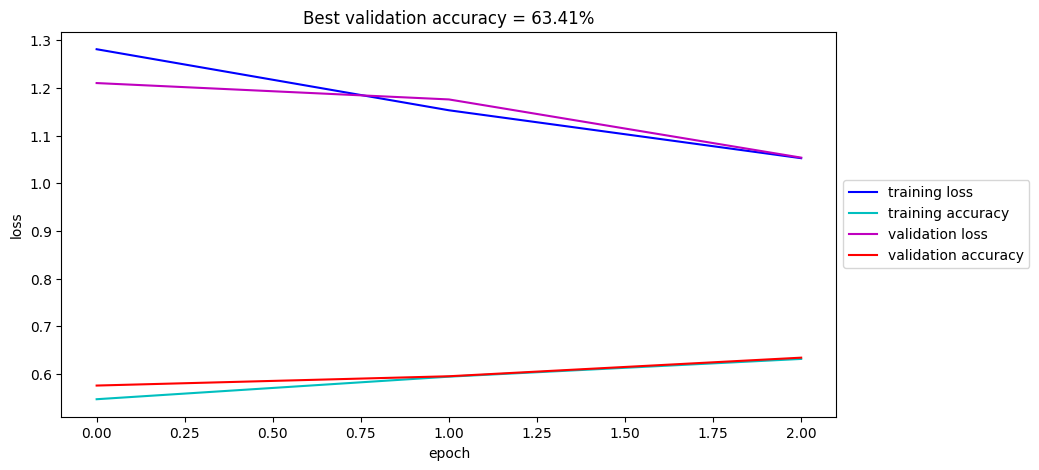

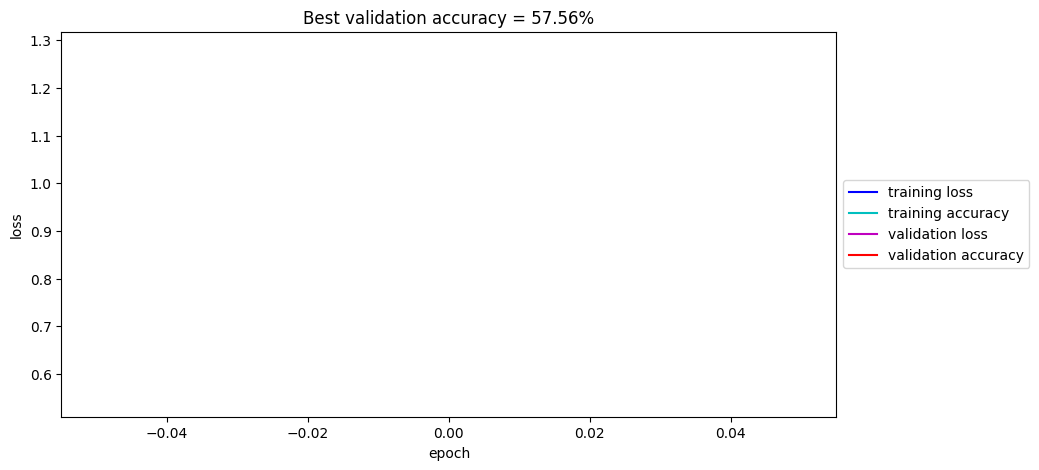

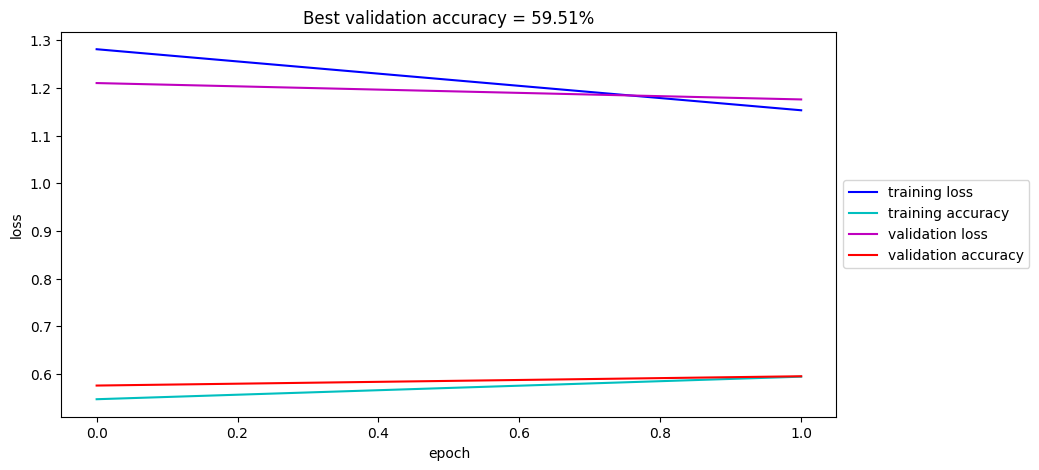

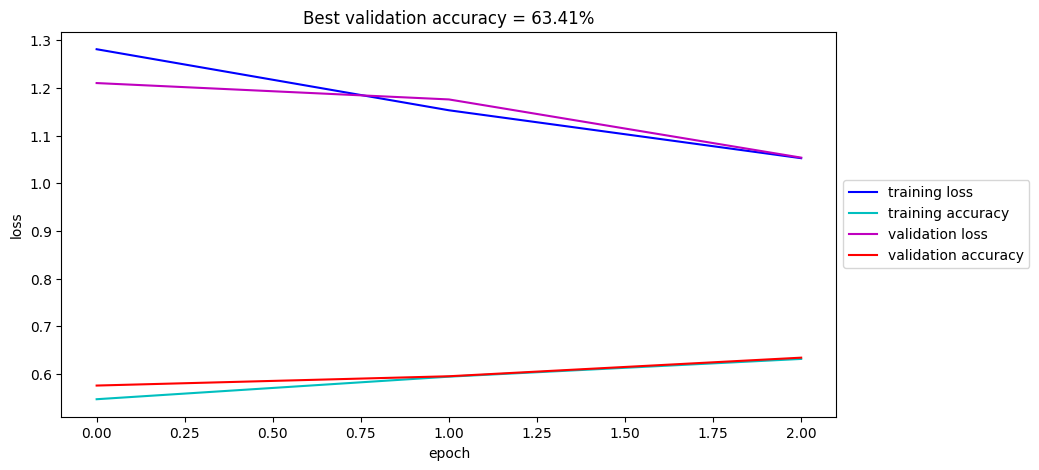

In [39]:
train_network(network, train_x, train_y_one_hot,
              val_x, val_y_one_hot, n_epoch, batch_size, network_filepath) #, network_filepath

In [13]:
network_filepath

'/Users/zah47/best_model_net_task_2.h5'

In [13]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network = keras.models.load_model(network_filepath)

network_name = 'network_task_2'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)
# write csv files with outputs
ho = open('/Users/zah47/results_{}.csv'.format(network_name), 'w') #you may need to specify the path
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


# Task 3: Add dropout layers
Modify the network and add dropout.

**Hint**: dropout is typically added to fully-connected layers, but it can be applied to convolutional layers as well.

In order to prepare and run the experiment, copy and modify previous cells to fill in the next three cells. 

In [16]:
def build_neural_network_drop(data_size_in, n_classes):
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(inputs)
    network_2 = layers.MaxPool2D(pool_size=(2, 2))(network_1)
    network_3 = layers.Dropout(0.25)(network_2)

    network_4 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Flatten()(network_6)
    network_8 = layers.Dense(128, activation='relu')(network_7)
    network_9 = layers.Dropout(0.25)(network_8)

    prediction = layers.Dense(n_classes, activation='softmax')(network_9)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [15]:
# Compile the network, you can copy code from the first task.
network = build_neural_network_drop(data_size_in, n_classes)
network.compile(loss=ls, optimizer=adam_opt, metrics=metric)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,914 (1015.29 KB)

 Trainable params: 259,914 (1015.29 KB)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
type(train_x)

numpy.ndarray

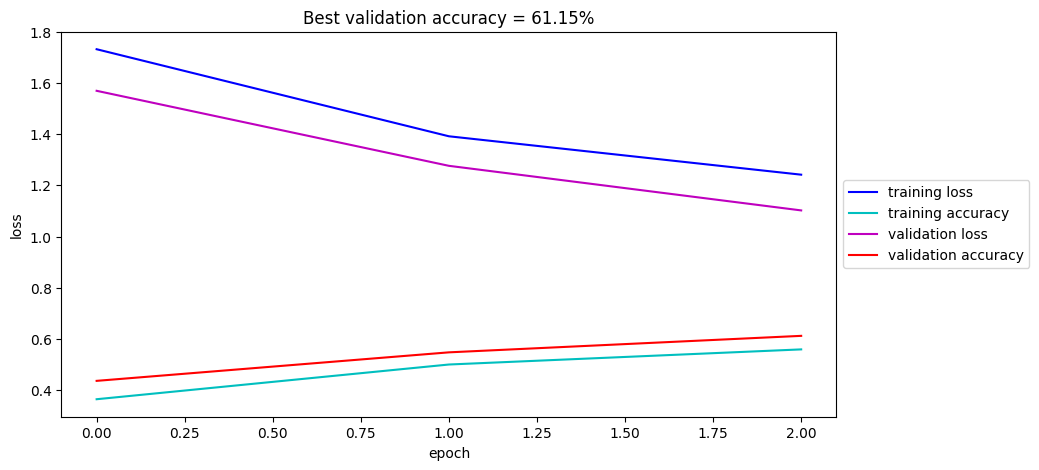

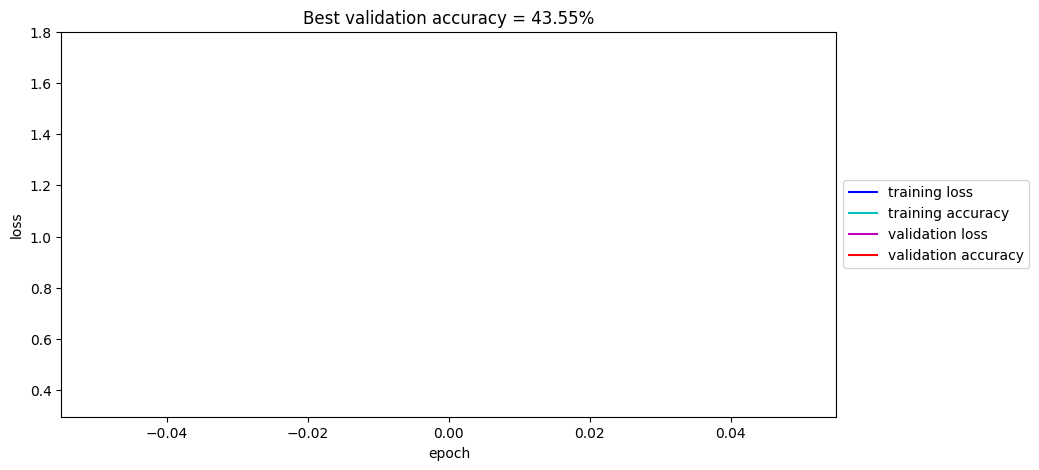

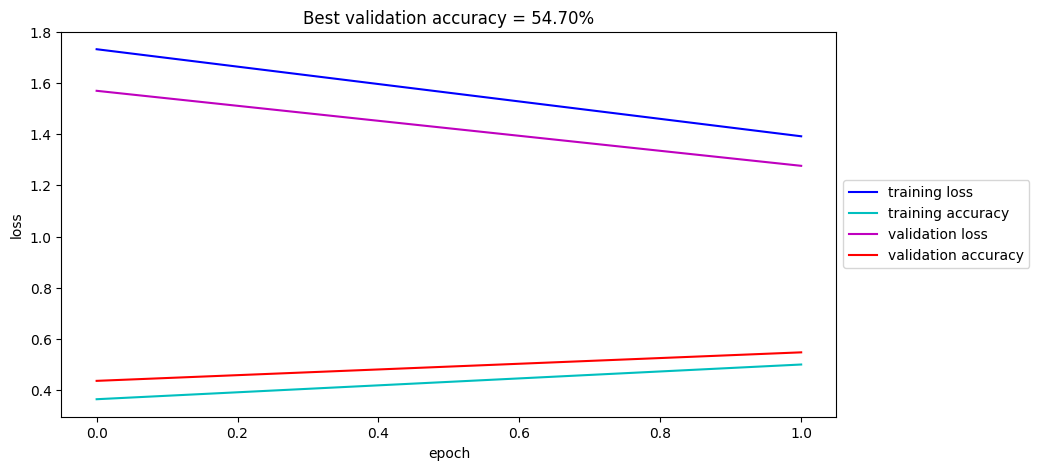

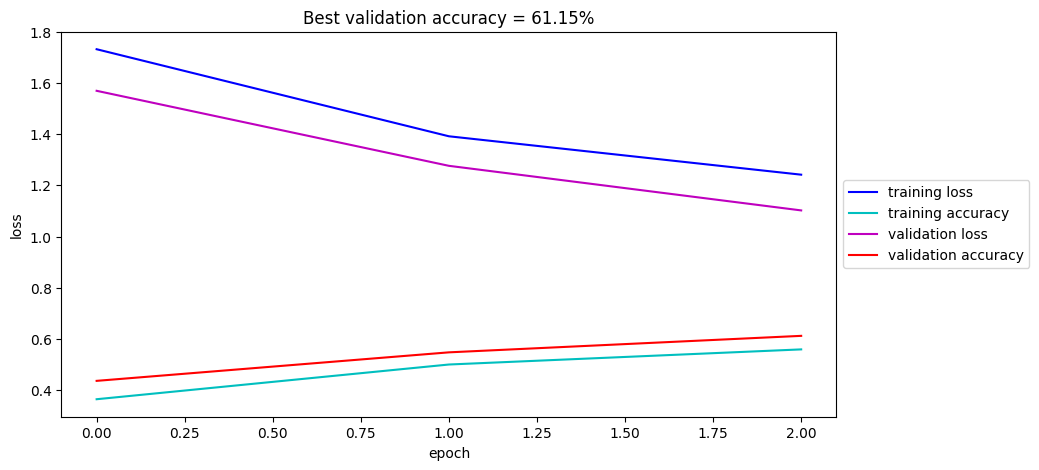

In [16]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_dropout.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

Before implementing the dropout layer, the validation loss starts to increase very early, while the training loss resumes to decline. This mismatch indicates that the network has begun to overfit. At this point, it is better to do something to prevent overfitting such as dropout. At each update of the training phase, the dropout layer tries setting the outgoing edges of hidden units (neurons that make up hidden layers) to zero. Thus, after adding these layers, the overfitting problem got almost improved as it can be seen the gap between training and validation loss curves has been removed and they are changing in the same pace.

In [19]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_3'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('/Users/zah47//results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


# Task 4: Add batch normalization
Add batch normalization to your network.

In [18]:
def build_neural_network_batch_norm(data_size_in, n_classes):

    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.MaxPool2D(pool_size=(2, 2))(network_2)
    network_4 = layers.Dropout(0.25)(network_3)

    network_5 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_4)
    network_6 = layers.BatchNormalization()(network_5)
    network_7 = layers.MaxPool2D(pool_size=(2, 2))(network_6)
    network_8 = layers.Dropout(0.25)(network_7)

    network_9 = layers.Flatten()(network_8)
    network_10 = layers.Dropout(0.25)(network_9)
    network_11 = layers.Dense(128, activation='relu')(network_10)
    network_12 = layers.BatchNormalization()(network_11)
    network_13 = layers.Dropout(0.25)(network_12)
    prediction = layers.Dense(n_classes, activation='softmax')(network_13)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [19]:
# Compile the network, you can copy code from the first task.
network = build_neural_network_batch_norm(data_size_in, n_classes)
network.compile(loss=ls, optimizer=adam_opt, metrics=metric)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,810 (1018.79 KB)

 Trainable params: 260,362 (1017.04 KB)

 Non-trainable params: 448 (1.75 KB)

None


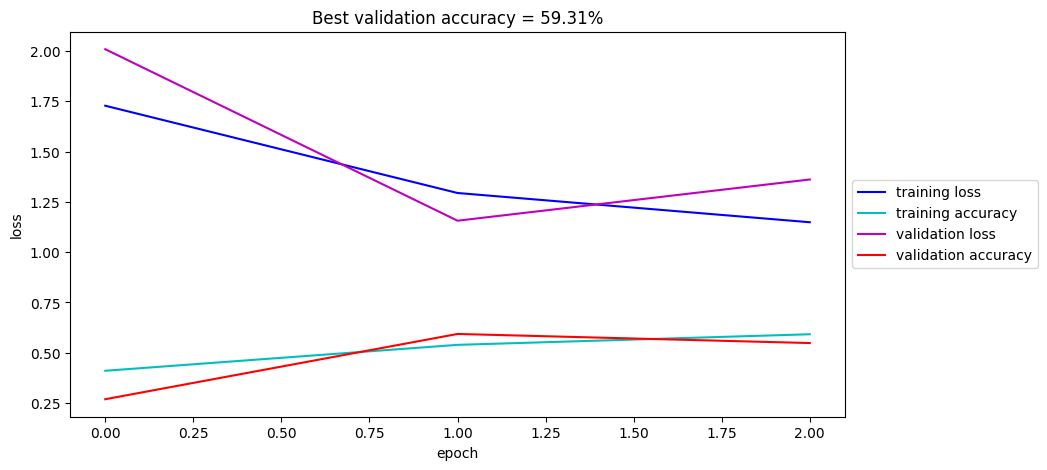

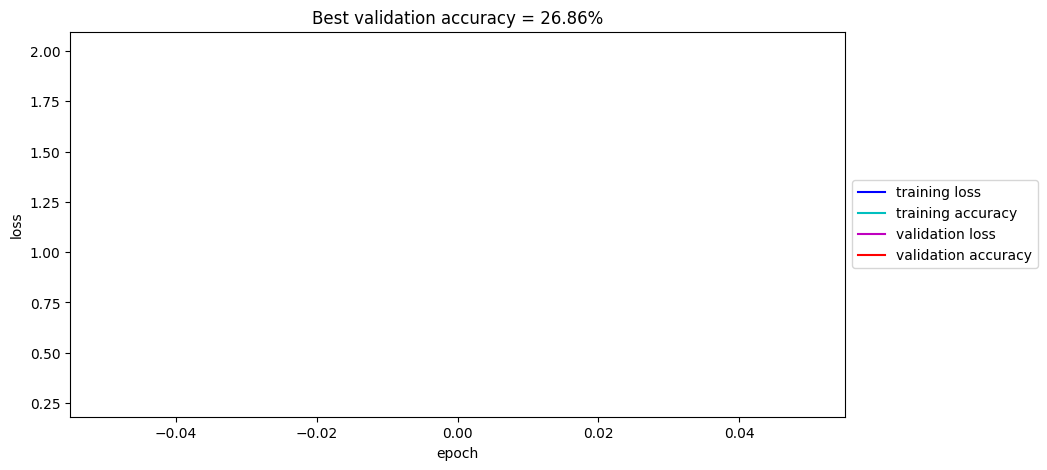

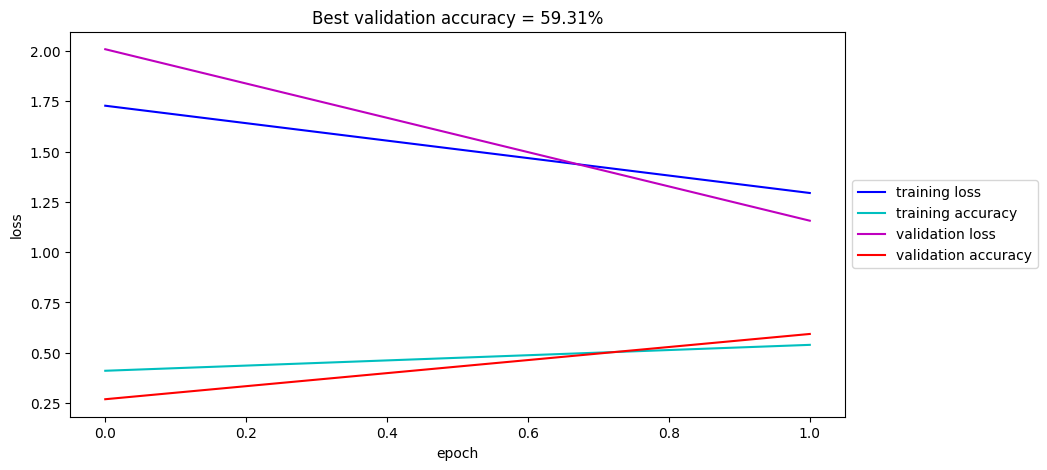

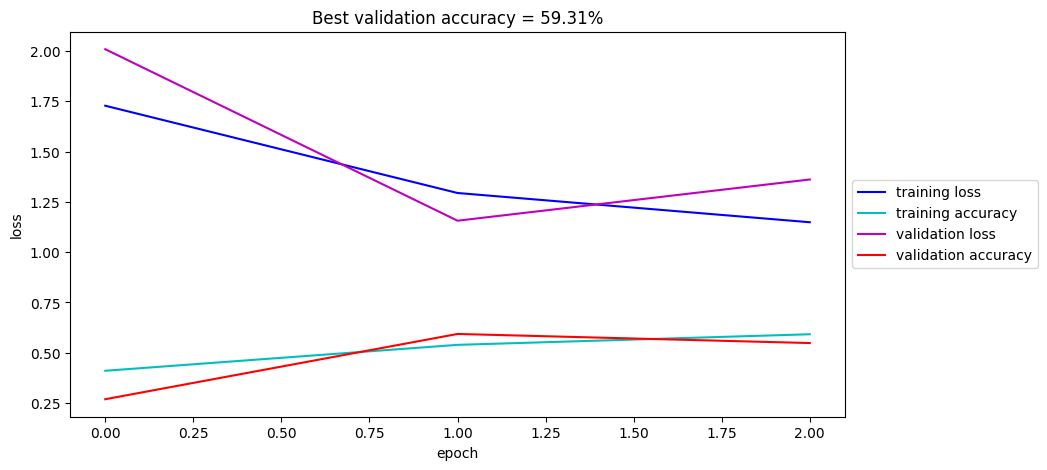

In [20]:
# train and validate the network
#network_filepath = os.path.join(file_dir, 'best_model_net_batchnorm.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [21]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)
network_name = 'network_task_4'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)
# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


OSError: [Errno 30] Read-only file system: './results_network_task_4.csv'

# Task 5: Try different initialization strategies
Try different Weight initialization strategies in the network. Make a new cell for each different strategy and retrain your network every time. Please see https://www.tensorflow.org/api_docs/python/tf/keras/initializers for examples.

1. Xavier Glorot: http://proceedings.mlr.press/v9/glorot10a.html
2. He: https://arxiv.org/abs/1502.01852

In [22]:
def build_neural_network_diff_init(data_size_in, n_classes):
    # Apparently, He is more compatible with relu and Glorot is more adjustable with tanh
    initializer = tf.keras.initializers.HeNormal()
    bias_init = tf.keras.initializers.zeros()

    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same',
                              kernel_initializer=initializer, bias_initializer=bias_init)(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_2)
    network_4 = layers.BatchNormalization()(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(network_6)
    network_8 = layers.BatchNormalization()(network_7)
    network_9 = layers.MaxPool2D(pool_size=(2, 2))(network_8)
    network_10 = layers.Dropout(0.25)(network_9)

    network_11 = layers.Flatten()(network_10)
    network_12 = layers.Dense(256, activation='relu',
                              kernel_initializer=initializer)(network_11)
    network_13 = layers.BatchNormalization()(network_12)
    network_14 = layers.Dropout(0.25)(network_13)
    network_15 = layers.Dense(128, activation='relu',
                              kernel_initializer=initializer)(network_14)
    network_16 = layers.BatchNormalization()(network_15)
    network_17 = layers.Dropout(0.25)(network_16)

    prediction = layers.Dense(n_classes, activation='softmax')(network_17)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [23]:
# Compile the network, you can copy code from the first task.

network = build_neural_network_diff_init(data_size_in, n_classes)
network.compile(loss=ls, optimizer=adam_opt, metrics=metric)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 399,978 (1.53 MB)

 Trainable params: 398,890 (1.52 MB)

 Non-trainable params: 1,088 (4.25 KB)

None


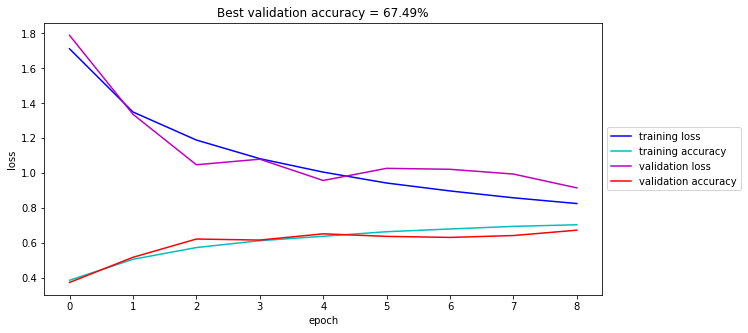

 3122/10000 [========>.....................] - ETA: 19s - loss: 0.9154 - acc: 0.6787

KeyboardInterrupt: ignored

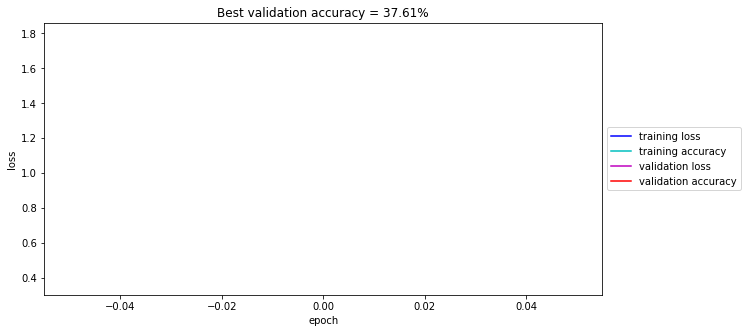

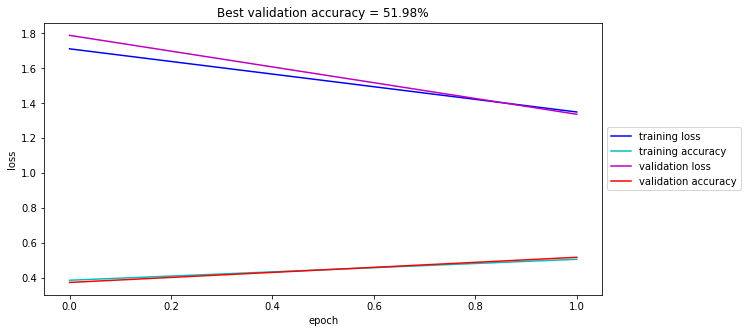

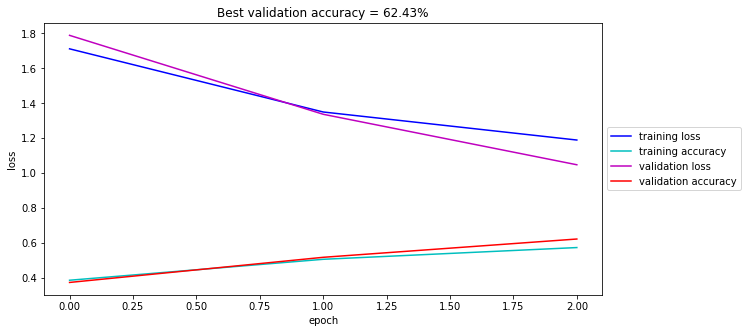

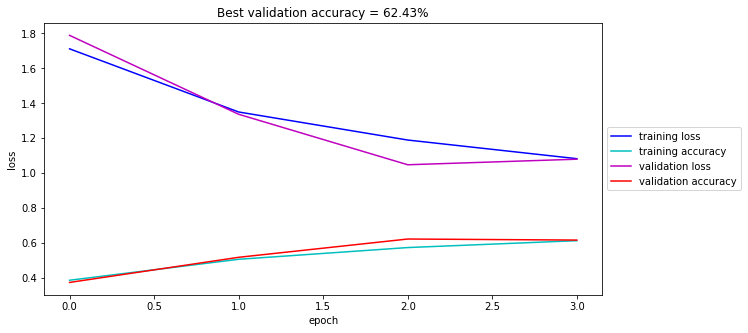

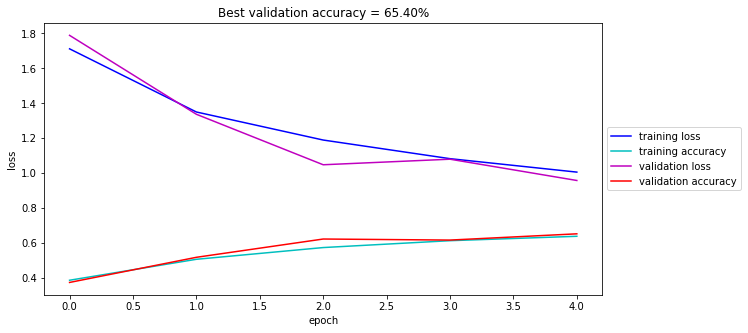

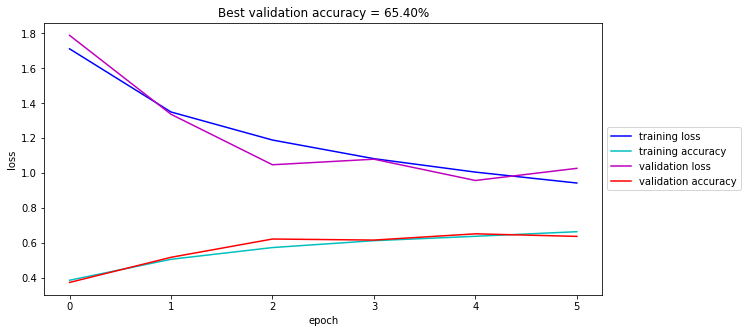

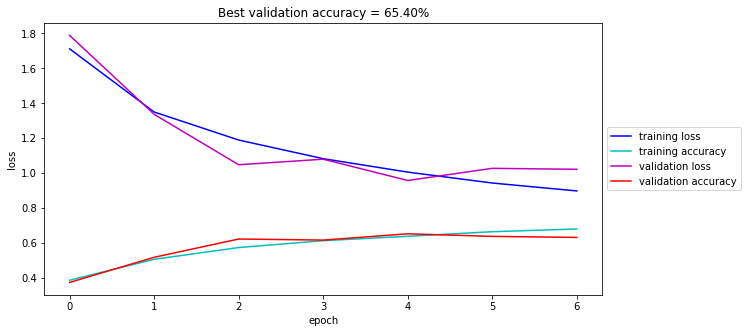

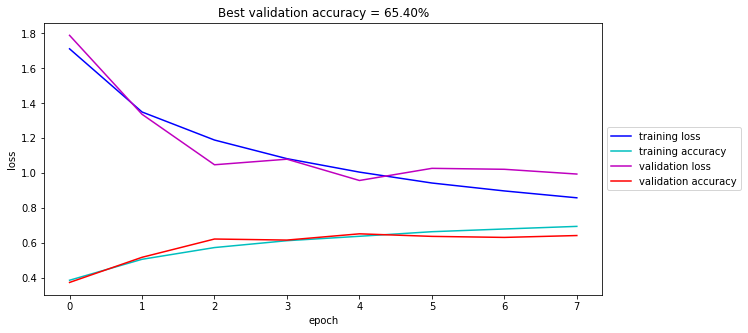

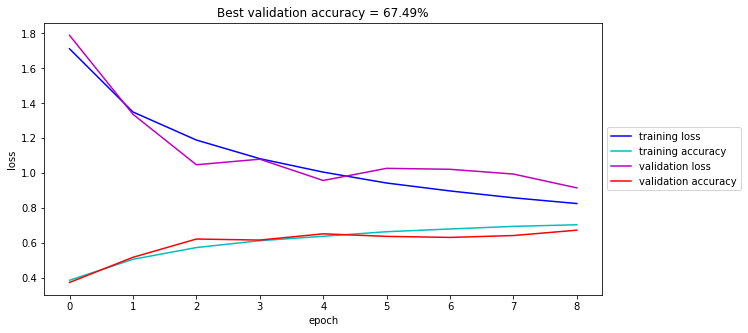

In [ ]:
# train and validate the network
#network_filepath = os.path.join(file_dir, 'best_model_net_init.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_5'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 6: Try different nonlinearities
Try different nonlinearities in the network. You can view supported activations functions in the Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/activations.

In [ ]:
def build_neural_network_diff_nonlin(data_size_in, n_classes):

    initializer = tf.keras.initializers.HeUniform()
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu', padding='same',
                              kernel_initializer=initializer)(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer)(network_2)
    network_4 = layers.BatchNormalization()(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Conv2D(32, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer)(network_6)
    network_8 = layers.BatchNormalization()(network_7)
    network_9 = layers.MaxPool2D(pool_size=(2, 2))(network_8)
    network_10 = layers.Dropout(0.25)(network_9)

    network_11 = layers.Flatten()(network_10)
    network_12 = layers.Dense(256, activation='gelu',
                              kernel_initializer=initializer)(network_11)
    network_13 = layers.BatchNormalization()(network_12)
    network_14 = layers.Dropout(0.25)(network_13)
    network_15 = layers.Dense(128, activation='gelu',
                              kernel_initializer=initializer)(network_14)
    network_16 = layers.BatchNormalization()(network_15)
    network_17 = layers.Dropout(0.25)(network_16)

    prediction = layers.Dense(n_classes, activation='softmax')(network_17)


    model = Model(inputs=inputs, outputs=prediction)

    print(model.summary())

    return model


In [ ]:
# Compile the network, you can copy code from the first task.
network = build_neural_network_diff_nonlin(data_size_in, n_classes)
network.compile(loss=ls, optimizer=adam_opt, metrics=metric)

In [ ]:
# train and validate the network
#network_filepath = os.path.join(file_dir, 'best_model_net_nonlin.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_6'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 7: L2 normalization
Add L2 regularization to your loss calculation. You can find examples at https://www.tensorflow.org/api_docs/python/tf/keras/regularizers.

In [ ]:
#from keras import regularizers

def build_neural_network_l2(data_size_in, n_classes):

    initializer = tf.keras.initializers.HeUniform()

    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu', padding='same',
                              kernel_initializer=initializer)(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer)(network_2)
    network_4 = layers.BatchNormalization()(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Conv2D(32, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer)(network_6)
    network_8 = layers.BatchNormalization()(network_7)
    network_9 = layers.MaxPool2D(pool_size=(2, 2))(network_8)
    network_10 = layers.Dropout(0.25)(network_9)

    network_11 = layers.Flatten()(network_10)
    network_12 = layers.Dense(256, activation='gelu', kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(1e-5))(network_11)
    network_13 = layers.BatchNormalization()(network_12)
    network_14 = layers.Dropout(0.25)(network_13)
    network_15 = layers.Dense(128, activation='gelu', kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(1e-5))(network_14)
    network_16 = layers.BatchNormalization()(network_15)
    network_17 = layers.Dropout(0.25)(network_16)

    prediction = layers.Dense(n_classes, activation='softmax')(network_17)


    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model


In [ ]:
# Compile the network, you can copy code from the first task.

network = build_neural_network_l2(data_size_in, n_classes)
network.compile(loss=loss, optimizer=sgd, metrics=metrics)

In [ ]:
# train and validate the network
#network_filepath = os.path.join(file_dir, 'best_model_net_l2.h5')

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_7'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 8: Add data augmentation

In this task I implement different data augmentation techniques. To do so, I will have to implement at least three functions that augment an image using some method.

I can use data augmentation libraries/frameworks (for example https://pillow.readthedocs.io).

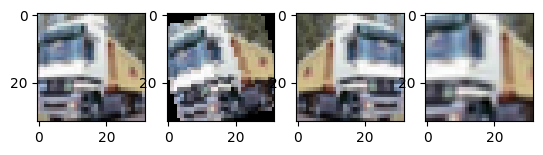

In [24]:
# Create (at least) three functions that take an image as input and return an augmented image
# Give them sensible names, describing the augmentation.
# from PIL import Image, ImageFilter
def augmentation_rotation(image):

    image = np.array(image)
    image *= 255
    image = image.astype(dtype=np.uint8)
    pillow_image = Image.fromarray(image)
    rotated = pillow_image.rotate(15)
    image = np.array(rotated)
    image = image.astype(dtype=np.float32)
    image /= 255.
    return image

def augmentation_flip_leftright(image):

    image = np.array(image)
    image *= 255
    image = image.astype(dtype=np.uint8)
    pillow_image = Image.fromarray(image)
    Fliped = pillow_image.transpose(Image.FLIP_LEFT_RIGHT)
    image = np.array(Fliped)
    image = image.astype(dtype=np.float32)
    image /= 255.
    return image

def augmentation_zoom(image):
    image = np.array(image)
    image *= 255
    image = image.astype(dtype=np.uint8)
    pillow_image = Image.fromarray(image)
    x, y, zoom = 16, 16, 1.3
    w, h = 32, 32
    zoom2 = zoom * 2
    zoomed = pillow_image.crop((x - w / zoom2, y - h / zoom2,
                    x + w / zoom2, y + h / zoom2))

    zoomed = zoomed.resize((w, h), Image.LANCZOS)
    image = np.array(zoomed)
    image = image.astype(dtype=np.float32)
    image /= 255.
    return image

# Fill this array with your augmentation functions
augmentations = [augmentation_rotation, augmentation_flip_leftright, augmentation_zoom]

# Preview your augmentations on an image
test_image = train_x[1].copy()
fig, axarr = plt.subplots(ncols=len(augmentations) + 1, nrows=1)
axarr[0].imshow((test_image))
for key, augment_func in enumerate(augmentations):
    axarr[key + 1].imshow(augment_func(test_image))
plt.show()

The function below takes the original data as input and returns an augmented dataset.

In [25]:
# Function to augment data
# The ratio defines how many of the images will be augmented.
def augment_data(original_data, ratio=0.4):

    data = original_data.copy()

    # Apply augmentations on a random portion of the data
    for augment_func in augmentations:
        indices = np.random.choice(len(data), int(len(data) * ratio))

        for i in indices:
            data[i] = augment_func(data[i])

    return data

Our train function needs to be adapted to work with the augmentations.

In [26]:
def pre_processing_AUG(x_training, y_training):
    y_training_2 = np.argmax(y_training, axis=1)

    x_training_aug = x_training.copy()
    y_training_aug = y_training_2.copy()

    for i in range(10):
      new_data = augment_data(x_training[y_training_2 == i])
      # new_data = np.array(new_data)
      x_training_aug = np.concatenate((x_training_aug, new_data))
      new_data_label = np.ones((len(new_data))) * i
      y_training_aug = np.concatenate((y_training_aug, new_data_label))

    x_training = x_training_aug
    y_training = tf.keras.utils.to_categorical(y_training_aug, num_classes=n_classes, dtype='float32')
    return x_training, y_training

def train_network_with_augmentations(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

    x_training, y_training = pre_processing_AUG(x_training, y_training)

    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit(x_training, y_training, batch_size=batch_size)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x=x_validation, y=y_validation, batch_size=1)
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt],
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [ ]:
#network_filepath = os.path.join(file_dir, 'best_model_net_augmentations.h5')

train_network_with_augmentations(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_8'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 9: Try different architectures

The architectures I used so far were pretty simple. I should try to build a different (deeper) architecture and see how it performs.

In [ ]:
def build_neural_network_deep_arch(data_size_in, n_classes):

    initializer = tf.keras.initializers.HeUniform()
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(64, kernel_size=(3, 3), activation='selu',
                              kernel_initializer=initializer, padding='same')(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(3, 3), activation='selu',
                              kernel_initializer=initializer, padding='same')(network_2)
    network_4 = layers.BatchNormalization()(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer, padding='same')(network_6)
    network_8 = layers.BatchNormalization()(network_7)
    network_9 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer, padding='same')(network_8)
    network_10 = layers.BatchNormalization()(network_9)
    network_11 = layers.MaxPool2D(pool_size=(2, 2))(network_10)
    network_12 = layers.Dropout(0.25)(network_11)

    network_13 = layers.Conv2D(128, kernel_size=(3, 3), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_12)
    network_14 = layers.BatchNormalization()(network_13)
    network_15 = layers.Conv2D(128, kernel_size=(3, 3), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_14)
    network_16 = layers.BatchNormalization()(network_15)
    network_17 = layers.MaxPool2D(pool_size=(2, 2))(network_16)
    network_18 = layers.Dropout(0.25)(network_17)

    network_19 = layers.Conv2D(128, kernel_size=(5, 5), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_18)
    network_20 = layers.BatchNormalization()(network_19)
    network_21= layers.Conv2D(128, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer, padding='same')(network_20)
    network_22 = layers.BatchNormalization()(network_21)
    network_23 = layers.MaxPool2D(pool_size=(2, 2))(network_22)
    network_24 = layers.Dropout(0.25)(network_23)

    network_25 = layers.Conv2D(256, kernel_size=(3, 3), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_24)
    network_26 = layers.BatchNormalization()(network_25)
    network_27 = layers.Conv2D(256, kernel_size=(3, 3), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_26)
    network_28 = layers.BatchNormalization()(network_27)
    network_29 = layers.MaxPool2D(pool_size=(2, 2))(network_28)
    network_30 = layers.Dropout(0.25)(network_29)

    network_31 = layers.Flatten()(network_30)

    network_32 = layers.Dense(512, activation='gelu', kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(1e-5))(network_31)
    network_33 = layers.BatchNormalization()(network_32)
    network_34 = layers.Dropout(0.25)(network_33)

    network_35 = layers.Dense(1024, activation='gelu', kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(1e-5))(network_34)
    network_36 = layers.BatchNormalization()(network_35)
    network_37 = layers.Dropout(0.25)(network_36)

    prediction = layers.Dense(n_classes, activation='softmax')(network_37)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [ ]:
# Compile the network, you can copy code from the first task.

network = build_neural_network_deep_arch(data_size_in, n_classes)
network.compile(loss=ls, optimizer=adam_opt, metrics=metric)

In [ ]:
# train and validate the network
#network_filepath = os.path.join(file_dir, 'best_model_net_deep.h5')
# first augmenting data
train_x, train_y_one_hot = pre_processing_AUG(train_x, train_y_one_hot)

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_9'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 10: Tools to monitor training procedure

There are different statistics that I could monitor to get a better understanding of how well the model is training. Such techniques could guide to improve the model in a number of ways. some ideas:

1. Monitor the norm of the weights of the network during training: and see if l2-regularization mitigates issues of overfitting by reducing this norm. What happends if I don't use l2-regularization, will this norm increase over time (after several epochs) and is it connected to overfitting in any way?
2. Monitor the norm of the gradient (the average of all nodes/layers, or per node/layer) during training to see if the network is actually learning from some gradient signal: and how this changes over time (over several epochs).
3. Visualize some of the filters of the CNN (sometimes referred to as kernels) and compare them (visually) before training (at random initialisation) and after training.

In [ ]:
from cv2 import resize
from matplotlib import pyplot
from tensorflow.keras.applications.vgg16 import preprocess_input
%matplotlib inline

In [ ]:
model = build_neural_network(data_size_in, n_classes)
model.compile(loss=ls, optimizer=adam_opt, metrics=metric)

In [ ]:
for layer in model.layers:
# check for convolutional layer
    if 'conv' not in layer.name:
        continue
# get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
# plot first few filters

n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure

pyplot.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from skimage.measure import block_reduce
import cv2


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from numpy import expand_dims

model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img('/content/sample_data/bird.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
    # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()